# Introduction

Investment theory argues that, assuming market efficiency, the optimal portfolio is a market-cap weighted portfolio of all investible assets. This is a simple attempt to construct such a "Global Market Portfolio" (GMP) using only Vanguard ETFs.

I will consider the investible universe to consit of stocks and bonds. Real estate is not included because the value of publicly traded real estate is very small relative to both the total value of global real estate and as a share of publicly traded assets.

To estimate market cap weights, I will use the market capitalization of the index that each Vanguard ETF tracks. There are several challenges in calculating these weights, however, which are outlined below.

### Vanguard Total World Stock ETF (VT)
The [Vanguard Total World Stock ETF (VT)](https://investor.vanguard.com/etf/profile/VT) reflects the performance of all publicly traded stocks globally. It tracks the FTSE Global All Cap Index. As of December 2019, this index had a market cap of $57,105,259M.


### Vanguard Total World Bond ETF (BNDW)
The [Vanguard Total World Bond ETF (BNDW)](https://investor.vanguard.com/etf/profile/BNDW) reflects the performance of all publicly traded bonds globally. It tracks the performance of the Bloomberg Barclays Global Aggregate Float Adjusted Composite Index. Unfortunatley, the market cap of this index is not publicly available. However, in their October 2019 paper *Historical Returns of the Market Portfolio*, Doeswijk, Lam, and Swinkels estimate that global bonds had a market cap 9% higher than that of stocks at the end of 2017 (see Table 5). We can combine this with the equity market cap at the end of 2017 to get a 2017 global bond market cap, and then use BNDW's growth since 2017 to update it to 2019.

#### Equity market cap at end of 2017
Old market cap values for the equity index were not available at the time of writing. However, using the growth values in the *FTSE Global All Cap Index Fact Sheet* for December 2019, we can calculate the market cap at the end of 2017:

$$57,105,259 \times \frac{1}{1 + 0.271} \times \frac{1}{1 - 0.096} = 49,700,656$$

#### Bond market cap at end of 2017
Adding 9% gives us the bond market cap:

$$49,700,656 \times 1.09 = 54,173,715$$

#### Bond market cap at end of 2019
BNDW did not exist at the end of 2017. However, its two components, BNDX and BND, did. BNDW is composed of 52% BNDX and 48% BND. Using prices of BND and BNDX in December 2015 and April 2019 and those weights, we see that BNDW would have grown by 4% over that period:

$$\frac {56.89}{54.37} \times .52 + \frac {84.27}{81.57} \times .48 = 1.04$$

Which implies a December 2019 bond market cap of $51.7T:

$$1.04 \times 49,700,656 = 51,688,171$$

### The Global Market Portfolio

Together, these imply the following weights of the GMP at the end of December 2019:


|  Fund  |       Asset Class       |    Market Cap   | GMP Weight |
|:------:|:-----------------------:|:---------------:|:----------:|
| VT     | Stocks                  | 57,105,259      | 52%        |
| BNDW   | Bonds                   | 51,688,171      | 48%        |


# Current GMP Weights and Returns

In this section, I pull the prices of the two ETFs that compose our GMP. I create the GMP using the weights above, and I calculate the YoY return.

In [15]:
import pandas as pd
import pandas_datareader as pdr
import pandas_datareader.data as web
import datetime as dt
from dateutil.relativedelta import relativedelta
import os
import leather
from IPython.display import SVG, display

In [16]:
#use pandas datareader to pull ETF prices
vt = (web.DataReader('VT', 'av-daily-adjusted',start = dt.datetime(2018, 9, 6),end = dt.date.today() - dt.timedelta(1),
                     api_key='143XC06PDFAI31WO')['close'].reset_index())
bndw = (web.DataReader('BNDW', 'av-daily-adjusted',start = dt.datetime(2018, 9, 6),end = dt.date.today() - dt.timedelta(1),
                       api_key='143XC06PDFAI31WO')['close'].reset_index())
vt = vt.rename(columns={"close": "vt"})
bndw = bndw.rename(columns={"close": "bndw"})
prices = vt.merge(bndw, on = 'index')
prices.set_index('index', inplace=True)
prices.tail()

vt    bndw
index                    
2020-01-17  83.08  79.015
2020-01-21  82.55  79.200
2020-01-22  82.66  79.270
2020-01-23  82.57  79.450
2020-01-24  81.92  79.590

In [17]:
#calculate the GMP indexed to the last trading day in 2019, using the weights calculated in the Introduction
prices['GMP_Index'] = (
    0.52 * (prices['vt'] / prices['vt']['2019-12-30']) +
    0.48 * (prices['bndw'] / prices['bndw']['2019-12-30'])
)
prices['VT_Index'] = prices['vt'] / prices['vt']['2019-12-30']
prices['BNDW_Index'] = prices['bndw'] / prices['bndw']['2019-12-30']
prices['GMP_Index'] = prices['GMP_Index'] / prices['GMP_Index']['2019-12-30']

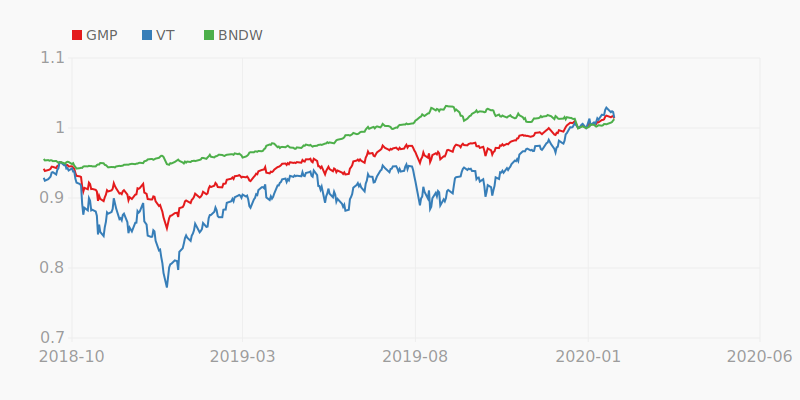

In [18]:
#chart the GMP index with the spectacular package leather; https://leather.readthedocs.io/en/0.3.3/
prices.reset_index(inplace = True)
prices['index'] = pd.to_datetime(prices['index'])
chart = leather.Chart()
chart.add_line(prices[['index', 'GMP_Index']].values.tolist(), name = 'GMP')
chart.add_line(prices[['index', 'VT_Index']].values.tolist(), name = 'VT')
chart.add_line(prices[['index', 'BNDW_Index']].values.tolist(), name = 'BNDW')
chart.to_svg('GMP.svg', height = 400, width = 800)
prices.set_index('index', inplace=True)
display(SVG('GMP.svg'))

### Calculate the current equities weight in the GMP
A feature of market-cap weighting is that the portfolio will rebalance itself over time. That is, if stocks outperform bonds, your portfolio will automatically have an increased weight to stocks relative to bonds, without having to do any trading. However, the weights calculated in the Introduction are valid only for portfolios built on 12/30/2019; any subsequent portfolios will have to recalculate the weights to account for changes in ETF prices. The section below calculates the current weight of VT and BNDW in the GMP, given price changes since 12/30/2019.

In [19]:
prices['vt_wt'] = (0.52 * (prices['vt'] / prices['vt']['2019-12-30']))
prices['bndw_wt'] = (0.48 * (prices['bndw'] / prices['bndw']['2019-12-30']))
prices['vt_wt'] = prices['vt_wt'] / (prices['vt_wt'] + prices['bndw_wt'])
prices['bndw_wt'] = 1 - prices['vt_wt']
vt_wt_cur = prices['vt_wt'].tail(1)[0]
print('Current VT weight in GMP:', round(vt_wt_cur,3))
print('Current BNDW weight in GMP:', round(1 - vt_wt_cur,3))

Current VT weight in GMP: 0.521
Current BNDW weight in GMP: 0.479


### GMP Return

In [20]:
#calculate the year-over-year return of the GMP
print('YoY Return:', round(prices['GMP_Index'].resample('D').ffill().pct_change(periods = 365).tail(1)[0],3))

YoY Return: 0.121


In [21]:
print('Last Updated: ', dt.datetime.today())

Last Updated:  2020-01-26 19:55:16.601305
